#Binary class image classification with Perceptron

In [ ]:
import numpy as np
import os
import io
import warnings

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

The dataset used is MNIST dataset that contais digit images. Each image should be labelled properly.

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
target_names = np.unique(y)
print('Number of samples, type: ', X.shape[0], X.dtype)
print('Number of features: ', X.shape[1])
print('Minimum: ', np.min(X), 'Maximum: ', np.max(X))
print('Number of classes: ', len(target_names), 'type: ', y.dtype)
print('labels: ', target_names)

Number of samples, type:  70000 float64
Number of features:  784
Minimum:  0.0 Maximum:  255.0
Number of classes:  10 type:  object
labels:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* MNIST dataset is clean and the range of values that each feature can take is also known. So the samples in the dataset does not require much preprocessing techniques.
* But it is better to scale the range of features between 0 and 1. 
* So we can either use MinMaxScaler or MaxAbsScaler. They dont make any difference as the image pixels can take only positive values ranging from 0 to 255.

In [ ]:
X = MinMaxScaler().fit_transform(X)
print('Minimum: ', np.min(X), ', Maximum: ', np.max(X))

Minimum:  0.0 , Maximum:  1.0


#Data Visualization
The images are stacked as a row vector of size 1 x 784. This must be reshaped to the matrix of size 28 x 28 to display properly. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


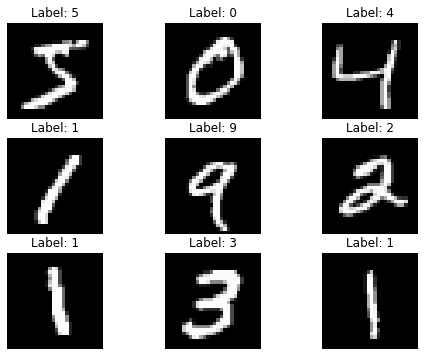

In [ ]:
num_images = 9
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+ i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

#Data Splitting
Since the samples in the data are randomly shuffled, no need to shuffle it again. So use of train_test_split may be skipped.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each class.

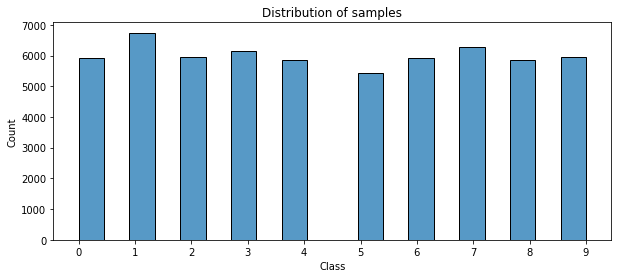

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

#Binary Classification - 0 Detection

##Modifying labels
* Let us first consider a simple classification problem - binary classification
* Since the original label vector contains 10 classes, we need to modify the number of classes to 2.
* The label 0 will be changed to 1 and other labels (1-9) will be changed to -1.
* The label vectors named as y_train_0 and y_test_0

In [ ]:
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find the indices of digit 0
indx_0 = np.where(y_train == '0') # oroginal labels are str, not int
#use these indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1 
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

##Baseline Model
1. Count the no of samples per class
2. The model always output the class which has the highest no of samples.
3. Then calculate the accuracy of the baseline model.

In [ ]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [ ]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print('training accuracy: ', base_clf.score(X_train, y_train_0))
print('test accuracy: ', base_clf.score(X_test, y_test_0))

training accuracy:  0.9012833333333333
test accuracy:  0.902


Now the reason is obvious. The model would have predicted 54077 samples correclty just by outputting -1 for all the input samples. Therefor the accuracy will be 54077/60000 = 90.12%.  
This is the reason why "accuracy" alone is not always a good measure

#Perceptron Model

In [ ]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
bin_clf.fit(X_train, y_train_0)
print('Dimension of weights {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('Loss function: {0}'.format(bin_clf.loss_function_))

Dimension of weights (1, 784)
Bias: [-108.]
Loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7fc92ef3f150>


Let us make prediction on training set and calculate training accuracy

In [ ]:
y_hat_train_0 = bin_clf.predict(X_train)
print('Traininig accuracy: ', bin_clf.score(X_train, y_train_0))

Traininig accuracy:  0.99095


In [ ]:
print('Testing accuracy: ', bin_clf.score(X_test, y_test_0))

Testing accuracy:  0.989


##Displaying Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


''

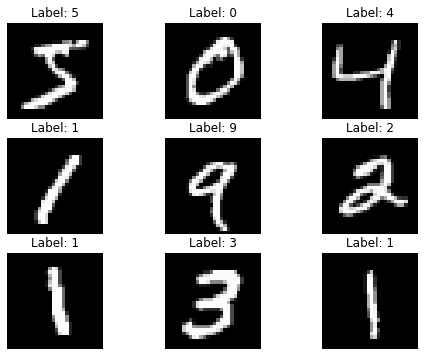

In [ ]:
y_hat_test_0 = bin_clf.predict(X_test)
num_images=9
factor=np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()
;

Display images of positive class from test set along with their predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


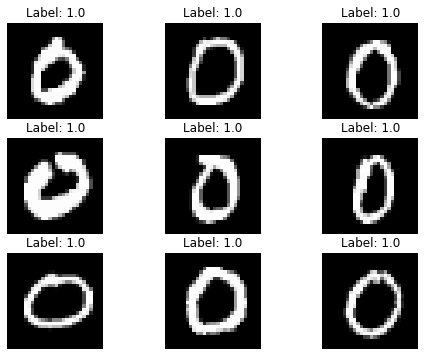

In [ ]:
indx_0 = np.where(y_test_0==1)
zeroImgs=X_test[indx_0[0]]
zeroLabs=y_hat_test_0[indx_0[0]]
num_images=9
factor=np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset=0
for i in range(factor):
  index=idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(zeroLabs[index+j])))
    ax[i,j].set_axis_off()

In [ ]:
num_misclassified = np.count_nonzero(zeroLabs==-1)
num_correct_pred = len(zeroLabs) - num_misclassified
accuracy = num_correct_pred / len(zeroLabs)
print(accuracy)

0.9193877551020408


#Better Evaluation Metrics

##Confusion Matrix

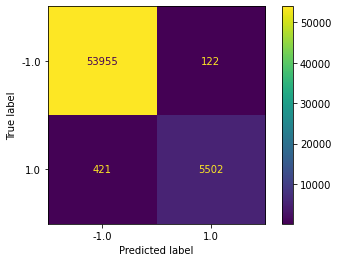

In [ ]:
y_hat_train_0 = bin_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

##Precision and Recall

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[0,1]
fp = cf_matrix[1,0]
tp = cf_matrix[1,1]

precision = tp/(tp+fp)
print('Precision: ', precision)
recall = tp/(tp+fn)
print('Recall: ', recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('accuracy: ', accuracy)

Precision:  0.9289211548201924
Recall:  0.9783072546230441
accuracy:  0.99095


##Cross Validation

In [ ]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.16006517, 2.41571593, 1.73967385, 1.51254272, 1.96721816]),
 'score_time': array([0.09452796, 0.04168749, 0.04144454, 0.06128263, 0.08224702]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [ ]:
print('f1:         avg:{0:.2f}, std:{0:.2f}'.format(scores['test_f1'].mean(), scores['test_f1'].std()))
print('precision:  avg:{0:.2f}, std:{0:.2f}'.format(scores['test_precision'].mean(), scores['test_precision'].std()))
print('recall:     avg:{0:.2f}, std:{0:.2f}'.format(scores['test_recall'].mean(), scores['test_recall'].std()))

f1:         avg:0.94, std:0.94
precision:  avg:0.96, std:0.96
recall:     avg:0.92, std:0.92


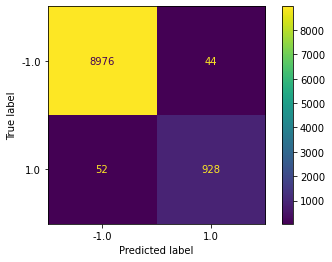

In [ ]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')
plt.show()

In [ ]:
print('Precision %.2f'%precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


###Way-2 for Generalization

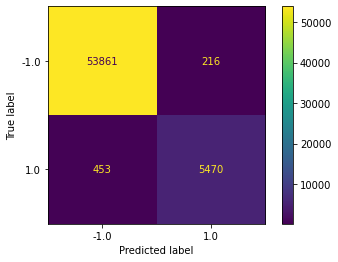

In [ ]:
y_hat_train_0 = cross_val_predict(bin_clf, X_train, y_train_0, cv=5)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[0,1]
fp = cf_matrix[1,0]
tp = cf_matrix[1,1]

precision = tp/(tp+fp)
print('Precision: ', precision)
recall = tp/(tp+fn)
print('Recall: ', recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('accuracy: ', accuracy)

Precision:  0.9235184872530812
Recall:  0.9620119591980303
accuracy:  0.98885


In [ ]:
print('Precision %.2f'%precision_score(y_train_0, y_hat_train_0))
print('Recall %.2f'%recall_score(y_train_0, y_hat_train_0))
print('-'*50)
print(classification_report(y_train_0, y_hat_train_0))

Precision 0.96
Recall 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#Precesion Recall Tradeoff
* Often we need to make a trade off between precision and recall scores of a model depends on the problem at hand.
* It is important to note that we should **not** pass the **predicted labels** as input to precision_recall_curve function. Instead we need to pass the probability scores or the output from the decision function.
* The Perceptron() class contains decision_function method.
* Internally the decision scores are sorted, tps and fps will be computed by changing the threshold from index[0] to index[-1].

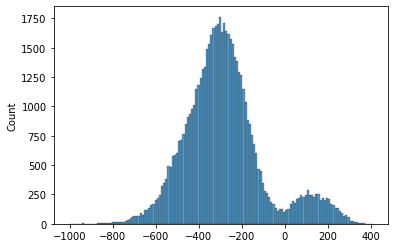

In [ ]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(X_train, y_train_0)
y_scores =  bin_clf.decision_function(X_train)
sns.histplot(np.sort(y_scores))
plt.show()

There are so many negative valuss than positive. Since the majority belongs to class -1. (Class Imbalance)
* Suppose threshold is set as -600, then all the values having score greater than -600 will be set to 1 (positive label) and less than it is set to -1 (negative label).
* Therefor the number of false positives will be increased.This will inturn reduce the precision score to a greater extend.
* On the other hand, if the threshold id set to 400, then the number of false negatives will be increased and hence recall will be reduces to great extend.

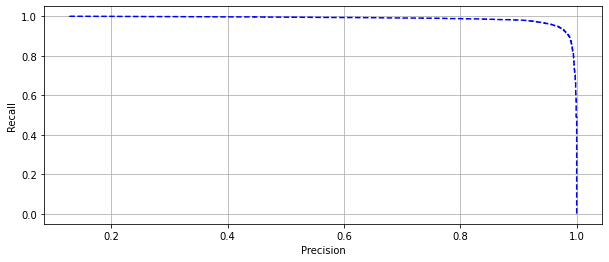

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)
plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

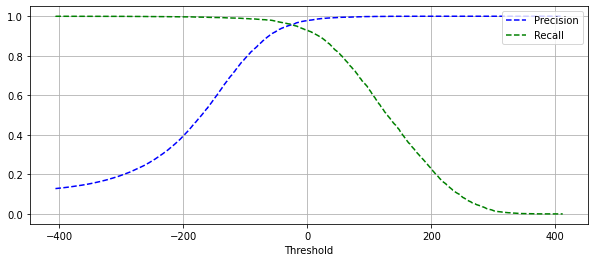

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
plt.plot(thresholds, recalls[:-1], "g--", label='Recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
#get the index of threshold around 0
idx_th = np.where(np.logical_and(thresholds>0, thresholds<1))
print('Precision for zero threshold: ', precisions[idx_th[0][0]])

Precision for zero threshold:  0.9783072546230441


#The ROC Curve

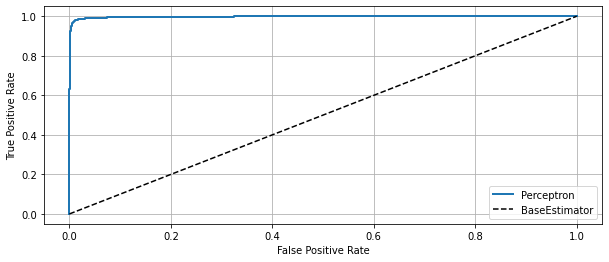

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0,1], [0, 1], 'k--', label='BaseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

#Warm Start vs Cold Start
## Cold Start
* IF we execute the fit method of bin_clf repeatedly, we get the same score for both training and testing accuracy.
* This is because, every time the fit methos is called, the model weights are initialized to the same values. Therefore we obtain the same score.
* The is termed as **Cold Start**. Let us executet the following 4 times and observe the score.

In [ ]:
bin_clf.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)
print('Training accuracy: ', bin_clf.score(X_train, y_train_0))
print('Test accuracy: ', bin_clf.score(X_test, y_test_0))

Training accuracy:  0.99095
Test accuracy:  0.989


##Warm Start
* Setting warm_start=True retains the weight values of the model afetr max_iter and hence produce different results for each execution. 
* Warm Start is useful in may ways. It helps us train the model by initializing the weight values from the previous state. So we can pause the traininig and resume it whenever we get the resource for computation.
* It is not required for simple models like Perceptron and for a small dataset like MNIST.
* Here we use this feature to plot iteration vs loss curve.
* Let us executet the following 4 times and see how accuracy changes after each each execution.

In [ ]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True)
bin_clf_warm.fit(X_train, y_train_0)
print('Training accuracy: ', bin_clf_warm.score(X_train, y_train_0))

Training accuracy:  0.99095
